In [2]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [4]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_l1024_o523_b4/"

In [3]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset+"dev/")
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset+"dev/")  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset+"dev/")

inputShape = X_train[0].shape

In [5]:
X_challenge, timepoints, challengeFileList = bbdc.load_challenge_data("challenge_filelist_dummy.csv", pathToDataset+"eval/")
inputShape = X_challenge[0].shape

In [9]:
print(tf.__version__)
print(X_train.shape)

2.4.1
(8000, 320, 128)


In [6]:
channels = [32, 64, 64]
model = unet.u_net(inputShape, channels, lessParameter = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 128)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 320, 32)      4128        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 320, 32)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
#Mit crossentropy
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
model = keras.models.load_model("model.h5")
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=100, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/100
534/534 [==============================] - 31s 51ms/step - loss: 0.0986 - mae: 0.0075 - accuracy: 0.9679 - val_loss: 0.1539 - val_mae: 0.0090 - val_accuracy: 0.9550

Epoch 00001: val_loss improved from inf to 0.15395, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 26s 49ms/step - loss: 0.0890 - mae: 0.0067 - accuracy: 0.9713 - val_loss: 0.1693 - val_mae: 0.0093 - val_accuracy: 0.9525

Epoch 00002: val_loss did not improve from 0.15395
Epoch 3/100
534/534 [==============================] - 26s 50ms/step - loss: 0.0866 - mae: 0.0066 - accuracy: 0.9718 - val_loss: 0.1533 - val_mae: 0.0089 - val_accuracy: 0.9553

Epoch 00003: val_loss improved from 0.15395 to 0.15335, saving model to model.h5
Epoch 4/100
534/534 [==============================] - 30s 56ms/step - loss: 0.0858 - mae: 0.0066 - accuracy: 0.9718 - val_loss: 0.1612 - val_mae: 0.0091 - val_accuracy: 0.9543

Epoch 00004: val_loss did not improve from 0.15335
Epoch 5/100
534/534 [=======

In [8]:
#Mit Dice
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=bbdc.dice_loss, metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=30, validation_data=(np.array(X_validation), np.array(Y_validation)))

Epoch 1/25
534/534 [==============================] - 9s 18ms/step - loss: 0.0824 - mae: 0.0270 - accuracy: 0.8597 - val_loss: 0.1570 - val_mae: 0.0491 - val_accuracy: 0.7272
Epoch 2/25
534/534 [==============================] - 9s 18ms/step - loss: 0.0783 - mae: 0.0256 - accuracy: 0.8666 - val_loss: 0.2714 - val_mae: 0.0779 - val_accuracy: 0.5334
Epoch 3/25
534/534 [==============================] - 10s 18ms/step - loss: 0.0740 - mae: 0.0242 - accuracy: 0.8741 - val_loss: 0.4289 - val_mae: 0.1102 - val_accuracy: 0.2892
Epoch 4/25
534/534 [==============================] - 10s 18ms/step - loss: 0.0715 - mae: 0.0233 - accuracy: 0.8783 - val_loss: 0.1611 - val_mae: 0.0462 - val_accuracy: 0.7256
Epoch 5/25
534/534 [==============================] - 10s 19ms/step - loss: 0.0682 - mae: 0.0222 - accuracy: 0.8843 - val_loss: 0.2628 - val_mae: 0.0730 - val_accuracy: 0.5525
Epoch 6/25
534/534 [==============================] - 10s 18ms/step - loss: 0.0660 - mae: 0.0215 - accuracy: 0.8877 - val_

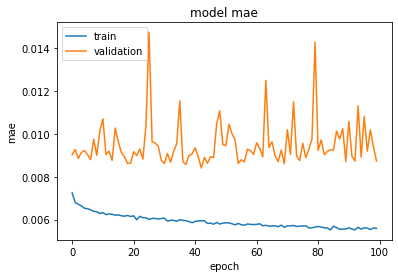

In [20]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

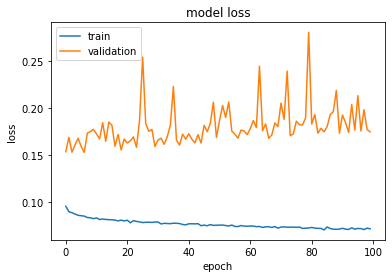

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

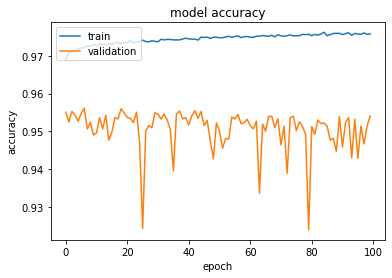

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [5]:
model = keras.models.load_model("Modelle_Jannes/model9561.h5")
prediction = model.predict(X_test)
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)

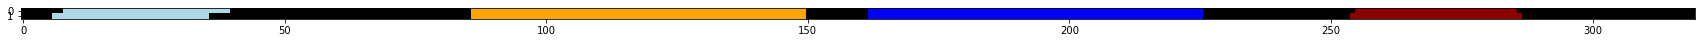

In [6]:
bbdc.plotPredictionAndGT(Y_test, prediction, 1)

In [7]:
scores = model.evaluate(X_test, Y_test)


32/32 [==============================] - 1s 12ms/step - loss: 0.1451 - mae: 0.0086 - accuracy: 0.9578


In [8]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_test.csv", index=False)
df.head()
evaluate.evaluate("../predictions/jannes/LP1d_Prediction_test.csv", "./../data/test.csv")

(0.5573403322374246, 'Valid file')

In [61]:
postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_pp_test.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_pp_test.csv", "./../data/test.csv"))

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


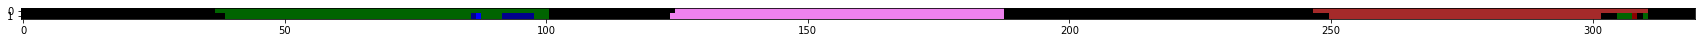

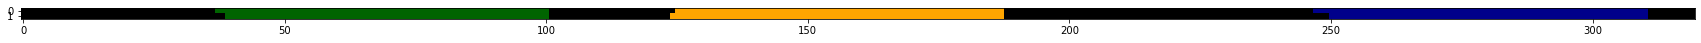

In [11]:
index = 0
bbdc.plotPredictionAndGT(Y_test, prediction, index) #TODO Problem mit falscher Farbdarstellung lösen
bbdc.plotPredictionAndGT(Y_test, postProcessedPrediction, index)

# Evaluation mit Validationset

In [12]:
prediction = model.predict(X_validation)
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)
model.evaluate(X_validation, Y_validation)
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_val.csv", "./../data/validation.csv"))

postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_pp_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_pp_val.csv", "./../data/validation.csv"))

32/32 [==============================] - 0s 10ms/step - loss: 0.1532 - mae: 0.0088 - accuracy: 0.9561
(0.5651359536722724, 'Valid file')
(0.9481987504924273, 'Valid file')


# Prediction der Challenge

In [8]:
model = keras.models.load_model("Modelle_Jannes/model9561.h5")
prediction = model.predict(X_challenge)
postProcessedPredictionChallenge = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPredictionChallenge, timepoints, challengeFileList, calculateProbs=True)
df.to_csv("../predictions/jannes/LP1d_PredictionChallenge_probs.csv", index=False)

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
